In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [3]:
def create_encoder(latent_dim):
  latent_dim = latent_dim
  encoder_inputs = keras.Input(shape=(784))
  x = layers.Dense(32, activation="relu")(encoder_inputs)
  x = layers.Dense(16, activation="relu")(x)
  z_mean = layers.Dense(latent_dim, name="z_mean")(x)
  z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
  z = Sampling()([z_mean, z_log_var])
  encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
  return encoder
 

In [4]:
def create_decoder(latent_dim):
  latent_dim = latent_dim
  latent_inputs = keras.Input(shape=(latent_dim + 1,))
  # cond_label = keras.Input(shape=(1,))
  # concat_input = tf.keras.layers.Concatenate()([latent_inputs, cond_label])
  x = layers.Dense(16, activation="relu")(latent_inputs)
  x = layers.Dense(32,activation="relu")(x)
  decoder_outputs = layers.Dense(28*28,activation="sigmoid")(x)

  decoder = keras.Model(inputs=latent_inputs, outputs=decoder_outputs, name="decoder")
  return decoder



In [5]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, combined_input):
        print(combined_input[0].shape)
        print(combined_input[1].shape)

        data = combined_input[0] # [0]
        label = combined_input[1]

        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            z_c = tf.keras.layers.concatenate([z, label])
            reconstruction = decoder(z_c)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = 5*tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [6]:
# Your input is here
import pandas as pd
data = pd.read_csv('ising_magnetization_data_wm100_img100_2')
print(data.head())
data_labels=np.array(data['0'])
data_labels = np.expand_dims(data_labels , -1).astype("float32")
temp = data['0'][0::100]
# drop the labels
data_wo_labels= data.drop(['Unnamed: 0','0'],axis=1)

data_in_array = np.array(data_wo_labels)
#data_in_2d_arrays = data_in_array.reshape((-1, 28, 28, 1))
#print(data_in_2d_arrays.shape)
print(data_in_array.shape)

   Unnamed: 0     0    1    2    3    4    5  ...  778  779  780  781  782  783  784
0           0  0.05  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0  1.0  1.0  1.0  1.0
1           1  0.05  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0  1.0  1.0  1.0  1.0
2           2  0.05  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0  1.0  1.0  1.0  1.0
3           3  0.05  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0  1.0  1.0  1.0  1.0
4           4  0.05  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0  1.0  1.0  1.0  1.0

[5 rows x 786 columns]
(5000, 784)


# Sección nueva

In [7]:
# data_wo_labels.head()
encoder=create_encoder(2)
decoder=create_decoder(2)
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           25120       input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 16)           528         dense[0][0]                      
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            34          dense_1[0][0]                    
____________________________________________________________________________________________

In [8]:
latent_dim = 2
encoder=create_encoder(latent_dim)
decoder=create_decoder(latent_dim)
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(data_in_array, data_labels, epochs=30, batch_size=2) # change to 10

Epoch 1/30
(2, 784)
(2, 1)
(2, 784)
(2, 1)
2500/2500 [==============================] - 8s 2ms/step - loss: 336.5614 - reconstruction_loss: 326.5918 - kl_loss: 9.9697
Epoch 2/30
2500/2500 [==============================] - 6s 2ms/step - loss: 326.1522 - reconstruction_loss: 318.5222 - kl_loss: 7.6300
Epoch 3/30
2500/2500 [==============================] - 5s 2ms/step - loss: 322.8189 - reconstruction_loss: 317.0078 - kl_loss: 5.8111
Epoch 4/30
2500/2500 [==============================] - 5s 2ms/step - loss: 321.4953 - reconstruction_loss: 316.5807 - kl_loss: 4.9145
Epoch 5/30
2500/2500 [==============================] - 5s 2ms/step - loss: 320.4443 - reconstruction_loss: 315.6006 - kl_loss: 4.8438
Epoch 6/30
2500/2500 [==============================] - 5s 2ms/step - loss: 319.6061 - reconstruction_loss: 315.1931 - kl_loss: 4.4130
Epoch 7/30
2500/2500 [==============================] - 5s 2ms/step - loss: 319.0706 - reconstruction_loss: 315.0208 - kl_loss: 4.0498
Epoch 8/30
2500/2500 [=

# Sampling

In [9]:
zeta=np.random.normal(size=latent_dim)
mag_data=[]
for t in temp:
  mag=0
  for i in range(100):
    zeta=list(np.random.normal(size=latent_dim))
    zeta.append(t)
    z_sample = [zeta]
    x_decoded = decoder.predict(z_sample)
    mag=np.abs(np.sum((2*np.array(x_decoded) - 1)/(28*28))) + mag
  mag_data.append(mag/100)



In [10]:
zeta=np.random.normal(size=latent_dim)
print(latent_dim)
print(decoder.summary())

[0.9999999636411667, 0.9999998980760574, 0.9999996936321258, 0.9999992001056671, 0.999998043179512, 0.9999952453374863, 0.9999848902225494, 0.9999366062879562, 0.9998709100484848, 0.9996475630998611, 0.9991127961874008, 0.9979828327894211, 0.9936815941333771, 0.993193039894104, 0.9907358008623123, 0.9827592384815216, 0.9700018656253815, 0.9686784970760346, 0.942195809930563, 0.9265259802341461, 0.8691129415482283, 0.8193365126848221, 0.6757675998657942, 0.48641587283462284, 0.31601439372636375, 0.16201209128601476, 0.13108733383007348, 0.09244096788577735, 0.08497019372996874, 0.06645856909221039, 0.06742165909614414, 0.06808576292940416, 0.061019894283963365, 0.04668735724873841, 0.048965240591205654, 0.04752888096496463, 0.039102864548331125, 0.0389481721422635, 0.0316094999096822, 0.033791546559077686, 0.026466517017106526, 0.021248038921621627, 0.023181693168589847, 0.022931864850688724, 0.013923025146359578, 0.016037538410164417, 0.015246204219292849, 0.018526508035720327, 0.01597

In [14]:

decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                64        
_________________________________________________________________
dense_8 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_9 (Dense)              (None, 784)               25872     
Total params: 26,480
Trainable params: 26,480
Non-trainable params: 0
_________________________________________________________________


In [15]:
def magnetization(t):
    return (1-(np.sinh(2/t)**(-4)))**(0.125)

In [16]:
x_data = np.arange(.05,3.5,0.001)
data_y = [magnetization(t) for t in x_data]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


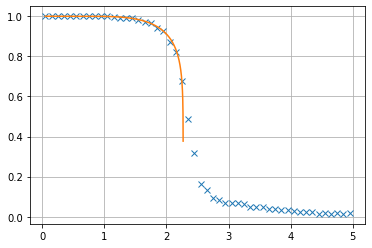

In [17]:
import matplotlib.pyplot as plt
plt.plot(temp,mag_data,'x',x_data,data_y)


plt.grid()

In [ ]:
np.savetxt("dense_data1_exp",mag_data)